In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def my_imfilter(image, kernel, edge='pad'):
    # get shapes and sizes
    if image.ndim==2: # grayscale
        m,n = image.shape
        l = 1
        image = image.reshape(m,n,1)
    else: # RGB
        m,n,l = image.shape
    assert(kernel.shape[0] %2 != 0) # must be odd
    assert(kernel.shape[1] %2 != 0) # must be odd
    k1 = int((kernel.shape[0]-1)/2)
    k2 = int((kernel.shape[1]-1)/2)
    
    kernel_sum = np.sum(kernel)
    if(kernel_sum <= 0):
        kernel_sum = 1
    
    # apply padding to image
    if edge=='pad': # zero-padding
        for i in range(k1):
            image = np.vstack((np.zeros((1,n,l)), image, np.zeros((1,n,l))))
        for i in range(k2):
            image = np.hstack((np.zeros((m+2*k1,1,l)), image, np.zeros((m+2*k1,1,l))))
    elif edge=='reflection': # copy from image
        for i in range(k1):
            image = np.vstack((image[i,:,:].reshape(1,-1,l), image, image[i,:,:].reshape(1,-1,l)))
        for i in range(k2):
            image = np.hstack((image[:,i,:].reshape(-1,1,l), image, image[:,i,:].reshape(-1,1,l)))
    else:
        raise("boundary condition not recogized; options are pad and reflection")
        
    # initialize output image
    G = np.zeros(image.shape)
        
    # apply kernel
    for k in range(l):
        for i in range(0,m+k1):
            for j in range(0,n+k2):
                val = 0
                if(k1 == 0 and k2 == 0):
                    val = kernel[0,0]*image[i,j,k]
                elif(k1 == 0):
                    for v in range(-k2,k2+1):
                        val += (kernel[0,1-v]*image[i, j-v, k])
                elif(k2 == 0):
                    for u in range(-k1,k1+1):
                        val += (kernel[1-u,0]*image[i-u, j, k])
                else:
                    for u in range(-k1,k1+1):
                        for v in range(-k2,k2+1):
                            val += (kernel[1-u,1-v]*image[i-u, j-v, k])
                G[i,j,k] = val/kernel_sum
            
    # remove padding
    G = G[k1:m+k1,k2:n+k2]
    
    # if grayscale remove extra dimension
    if l==1:
        G = G.reshape(G.shape[0],G.shape[1])
    
    return G

1. Gradient Magnitude

In [3]:
def Gradient_Magnitude(image):
    # Sobel filters for partials in x and y directions
    grad_x_kernel = np.asarray([[1,0,-1],[2,0,-2],[1,0,-1]])
    grad_y_kernel = np.asarray([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    # get gradients
    grad_x = my_imfilter(image, grad_x_kernel)
    grad_y = my_imfilter(image, grad_y_kernel)
    
    # calculate magnitude
    mag = np.sqrt(grad_x**2 + grad_y**2)
    
    return mag

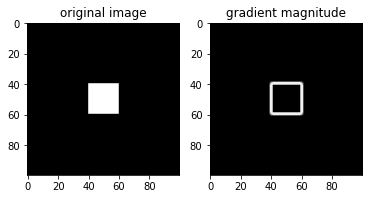

In [4]:
# test gradient magnitude
image1 = np.zeros((100,100))
image1[40:60,40:60] = 1

grad_mag = Gradient_Magnitude(image1)

plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.title("gradient magnitude")
plt.imshow(grad_mag, cmap='gray')
plt.show()

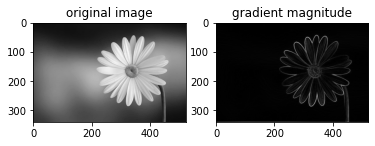

In [5]:
# test gradient magnitude
image2 = cv2.imread('flower.jpg',0).astype(np.float)

grad_mag = Gradient_Magnitude(image2)

plt.subplot(1,2,1)
plt.imshow(image2, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(grad_mag, cmap='gray')
plt.title("gradient magnitude")
plt.show()

2. Laplacian

In [6]:
def Laplacian_(image):
    image = cv2.GaussianBlur(image,(3,3),0) # guassian
    kernel = np.asarray([[0,1,0],[1,-4,1],[0,1,0]]) # laplacian

    
    laplacian = my_imfilter(image, kernel)
    
    return laplacian

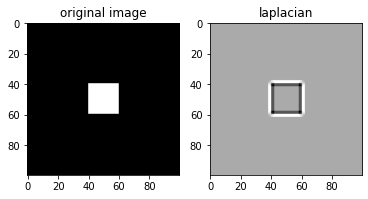

In [7]:
# test Laplacian
lap = Laplacian_(image1)

plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(lap, cmap='gray')
plt.title("laplacian")
plt.show()

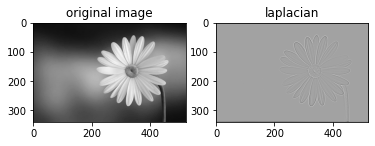

In [8]:
# test Laplacian
lap = Laplacian_(image2)

plt.subplot(1,2,1)
plt.imshow(image2, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(lap, cmap='gray')
plt.title("laplacian")
plt.show()

3. Zero Crossings

In [9]:
def Zero_Crossings(image):
    lap = Laplacian_(image) # get laplacian
    
    zc = np.zeros(lap.shape)
    
    # mark zero crossing if at least one neighbor is different sign
    for i in range(1,lap.shape[0]-1):
        for j in range(1,lap.shape[1]-1):
            if(lap.ndim==2): # grayscale
                if(lap[i,j]<0):
                    if(lap[i+1,j]>0 or lap[i,j+1]>0 or lap[i-1,j]>0 or lap[i,j-1]>0):
                        zc[i,j] = 1
            else: # RGB
                if(np.mean(lap[i,j,:])<0):
                    if(np.mean(lap[i+1,j,:])>0 or np.mean(lap[i,j+1,:])>0 or np.mean(lap[i-1,j,:])>0 or np.mean(lap[i,j-1,:])>0):
                        zc[i,j,:] = np.asarray([1,1,1])
    
    return zc.astype(bool)

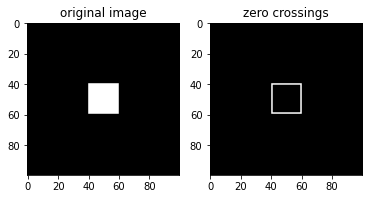

In [10]:
# test zero crossings
zc = Zero_Crossings(image1)

plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(zc, cmap='gray')
plt.title("zero crossings")
plt.show()

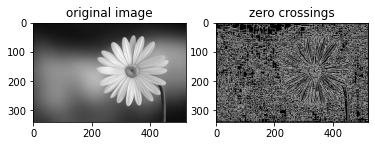

In [11]:
# test zero crossings
zc = Zero_Crossings(image2)

plt.subplot(1,2,1)
plt.imshow(image2, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(zc, cmap='gray')
plt.title("zero crossings")
plt.show()

4. Edge Detection

In [12]:
def Laplacian_Edge_Detection(image, thresh):
    grad_mag = Gradient_Magnitude(image)
    zc = Zero_Crossings(image)
    
    grad_mag = grad_mag > thresh # thresholding
    
    return zc & grad_mag

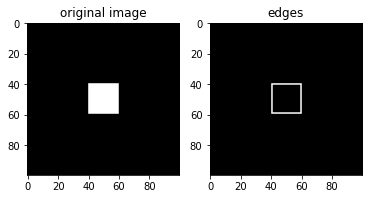

In [13]:
# test edge detection
edges = Laplacian_Edge_Detection(image1, .25)

plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("edges")
plt.show()

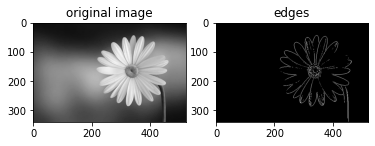

In [14]:
# test edge detection
edges = Laplacian_Edge_Detection(image2, 130)

plt.subplot(1,2,1)
plt.imshow(image2, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("edges")
plt.show()

5. More test images

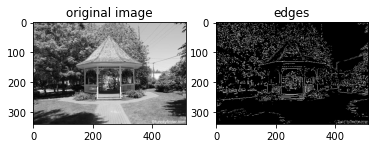

In [15]:
image3 = cv2.imread('zionsville.jpg',0).astype(np.float)

edges = Laplacian_Edge_Detection(image3, 250)

plt.subplot(1,2,1)
plt.imshow(image3, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("edges")
plt.show()

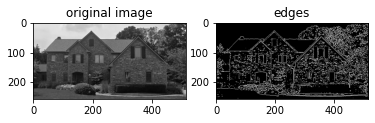

In [16]:
image4 = cv2.imread('home.png',0).astype(np.float)

edges = Laplacian_Edge_Detection(image4, 75)

plt.subplot(1,2,1)
plt.imshow(image4, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("edges")
plt.show()

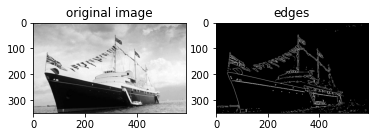

In [17]:
image5 = cv2.imread('britannia.jpg',0).astype(np.float)

edges = Laplacian_Edge_Detection(image5, 130)

plt.subplot(1,2,1)
plt.imshow(image5, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("edges")
plt.show()

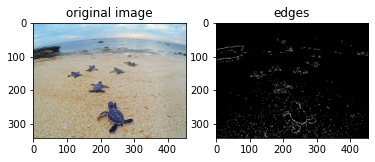

In [18]:
image6 = (cv2.imread('turtles.png')).astype(np.float)

# normalize
image6_show = (image6 - np.min(image6)) / (np.max(image6) - np.min(image6))

edges = Laplacian_Edge_Detection(image6, 225)

plt.subplot(1,2,1)
plt.imshow(image6_show[...,::-1])
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges[:,:,0], cmap='gray')
plt.title("edges")
plt.show()

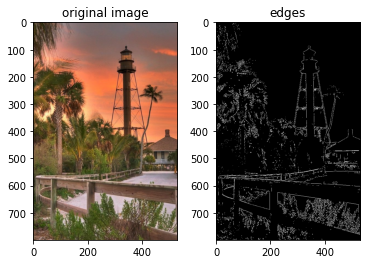

In [19]:
image7 = (cv2.imread('sancap.jpg')).astype(np.float)

# normalize
image7_show = (image7 - np.min(image7)) / (np.max(image7) - np.min(image7))

edges = Laplacian_Edge_Detection(image7, 200)

plt.subplot(1,2,1)
plt.imshow(image7_show[...,::-1])
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(edges[:,:,0], cmap='gray')
plt.title("edges")
plt.show()